In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
def bootstrap():
  !pip install -U albumentations
  !pip uninstall opencv-python-headless
  !pip install opencv-python-headless==4.5.2.52
  !pip list | grep opencv

  !mkdir -p /content/DataSets/LungSegmentationDataset/CXR_png
  !mkdir -p /content/DataSets/LungSegmentationDataset/masks
  !mkdir -p /content/DataSets/LungSegmentationDataset/results/saved_images

  !cp /content/drive/MyDrive/Colab\ Notebooks/DataSets/LungSegmentationDataset/CXR_png/*.* /content/DataSets/LungSegmentationDataset/CXR_png
  !cp /content/drive/MyDrive/Colab\ Notebooks/DataSets/LungSegmentationDataset/masks/*.* /content/DataSets/LungSegmentationDataset/masks

#bootstrap()

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.8 MB 2.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/d

In [ ]:
import os
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops, find_contours

In [ ]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 256  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_DATA_SET_TYPE = ''
MASK_SUFFIX_NO_EXTN = ''

XRAY = True
if XRAY:
  IMAGE_DATA_SET_TYPE = 'MCU'
  BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/DataSets/LungSegmentationDataset/'
  BASE_DIR = '/content/DataSets/LungSegmentationDataset/'
  IMAGE_DIR = BASE_DIR + "CXR_png/"
  MASK_DIR = BASE_DIR + "masks/"
  IMAGE_SUFFIX = ".png"
  MASK_SUFFIX = ".png"
else:
  BASE_DIR = '/content/DataSets/CarvanaDataSet/'
  IMAGE_DIR = BASE_DIR + "train_images/"
  MASK_DIR = BASE_DIR + "train_masks/"
  IMAGE_SUFFIX = ".jpg"
  MASK_SUFFIX = "_mask.gif"
  #MASK_SUFFIX_NO_EXTN = "_mask"

In [ ]:
DEVICE

'cpu'

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/DataSets/LungSegmentationDataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/DataSets/'

In [ ]:
image_names, mask_names = [], []
def preprocess_dataset():
  # CHN, MCU
  all_images = os.listdir(IMAGE_DIR)
  all_masks = os.listdir(MASK_DIR)
  mc_mask_names = [mask.split(MASK_SUFFIX)[0] for mask in all_masks if mask.startswith(IMAGE_DATA_SET_TYPE)]
  mc_image_names = [image.split(IMAGE_SUFFIX)[0] for image in all_images if image.startswith(IMAGE_DATA_SET_TYPE)]
  print(f'{IMAGE_DATA_SET_TYPE} Dataset:: Number of images: {len(mc_image_names)}, Number of masks: {len(mc_mask_names)}')


  # len([image for image in mc_image_names if (image + '_mask') not in mc_mask_names])
  print(f'Number of images missing masks: {len([image for image in mc_image_names if (image + MASK_SUFFIX_NO_EXTN) not in mc_mask_names])}')

  mask_names = mc_mask_names
  image_names = mc_image_names

  mask_names.sort()
  image_names.sort()

  return image_names, mask_names

image_names, mask_names = preprocess_dataset()

MCU Dataset:: Number of images: 138, Number of masks: 138
Number of images missing masks: 0


In [ ]:
train_indices, validation_indices = train_test_split(range(len(mask_names)), test_size=0.2, random_state=2022)
len(train_indices), len(validation_indices)

(110, 28)

In [ ]:
image_names[0:3], mask_names[0:3]

(['MCUCXR_0001_0', 'MCUCXR_0002_0', 'MCUCXR_0003_0'],
 ['MCUCXR_0001_0', 'MCUCXR_0002_0', 'MCUCXR_0003_0'])

In [ ]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint " + filename)
    torch.save(state, filename)

def load_checkpoint(model, filename):
    print("=> Loading checkpoint " + filename)
    if DEVICE == 'cpu':
      model.load_state_dict(torch.load(filename, map_location='cpu')["state_dict"])
    else:
      model.load_state_dict(torch.load(filename)["state_dict"])

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    dice_score = dice_score/len(loader)
    print(f"Dice score: {dice_score}")
    model.train()
    return dice_score

In [ ]:
def save_predictions_as_imgs(loader, model, folder="results/saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/true_{idx}.png")

    model.train()

In [ ]:
class CXRMaskDataset(Dataset):
    def __init__(self, indices, image_names, mask_names, image_dir, mask_dir, transform=None):
        self.indices = indices
        self.image_names = image_names
        self.mask_names = mask_names
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_names[self.indices[index]] + IMAGE_SUFFIX)
        mask_path = os.path.join(self.mask_dir, self.image_names[self.indices[index]] + MASK_SUFFIX)
        # print(f'img_path: {img_path}, mask_path: {mask_path}')
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

validation_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape
    
test()

In [ ]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    return loss.clone().detach().item()

0
(4892, 4020)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
contours 2
314 3630 1969 1675
294 3680 1949 1695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


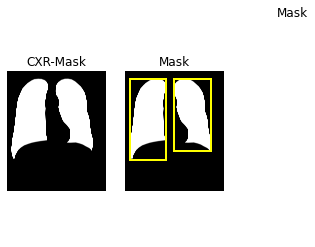

In [ ]:
import matplotlib.patches as patches
TMP = 0
def calculate_bounding_box_for_image(mask_image_path):
  global TMP
  print(TMP)
  image = np.array(Image.open(mask_image_path).convert("L"), dtype=np.float32)
  TMP = image
  print(image.shape)
  h, w = image.shape
  border = np.zeros((h, w))
  contours = find_contours(image, 128)

  print(image)
  print('contours', len(contours))
  for contour in contours:
      
      for c in contour:
          x = int(c[0])
          y = int(c[1])
          border[x][y] = 255
  lbl = label(border)
  props = regionprops(lbl)
  bboxes = []
  for prop in props:
    x1 = prop.bbox[1]
    y1 = prop.bbox[0]
    x2 = prop.bbox[3]
    y2 = prop.bbox[2]
    bboxes.append([x1, y1, x2, y2])

  # print('bboxes', bboxes)

  fig = plt.figure()

  fig.add_subplot(1,3,1)
  plt.axis('off')
  plt.imshow(image, cmap='gray')
  plt.title("CXR-Mask")

  axes = fig.add_subplot(1,3,2)
  plt.axis('off')
  plt.imshow(image, cmap='gray')
  for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='yellow', facecolor='none')
    axes.add_patch(rect)
  plt.title("Mask")

  axes = fig.add_subplot(1,3,3)
  plt.axis('off')
  x1 = bboxes[0][0]
  y1 = bboxes[0][1]
  x2 = bboxes[0][2]
  y2 = bboxes[0][3]
  x3 = bboxes[1][0]
  y3 = bboxes[1][1]
  x4 = bboxes[1][2]
  y4 = bboxes[1][3]
  print(y1,y4,x1,x4)
  print(y1-20,y4+50,x1-20,x4+20)
  plt.imshow(image[y1-20:y4+50,x1-20:x4+20], cmap='gray')
  plt.title("Mask")

  plt.show()


rand_idx = np.random.randint(0, len(mask_names)-1)
test_image = mask_names[rand_idx]
calculate_bounding_box_for_image(f'/content/DataSets/LungSegmentationDataset/masks/{test_image}.png')

In [ ]:
TMP

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def lung_region_image_generator(image_tensors, mask_image_tensors):
  assert image_tensors.shape, mask_image_tensors.shape

  cropped_image_tensors = torch.zeros_like(image_tensors)
  
  cropped_images = torch.zeros_like(image_tensors)

  mask_images_np = mask_image_tensors.cpu().detach().squeeze(1).numpy()

  num_images = mask_images_np.shape[0]
  for idx in range(num_images):
    #print(mask_images_np[idx].shape)
    image_tensor = image_tensors[idx]
    mask_image_np = mask_images_np[idx]

    image_height, image_width = image_tensor.shape[1], image_tensor.shape[2]
    #print(f'image_height: {image_height}, image_width: {image_width}')

    mask_height, mask_width = mask_image_np.shape
    border = np.zeros((mask_height, mask_width))
    contours = find_contours(mask_image_np, 0.5)

    #print('num contours', len(contours))
    for contour in contours:  
      for c in contour:
        x = int(c[0])
        y = int(c[1])
        border[x][y] = 255

    lbl = label(border)
    props = regionprops(lbl)
    bboxes = []
    for prop in props:
      # Bounding box (min_row, min_col, max_row, max_col)
      x1 = prop.bbox[1]
      y1 = prop.bbox[0]
      x2 = prop.bbox[3]
      y2 = prop.bbox[2]
      bboxes.append([x1, y1, x2, y2])
    #print('bboxes', bboxes)


    x1 = bboxes[0][0]
    y1 = bboxes[0][1]
    x2 = bboxes[0][2]
    y2 = bboxes[0][3]
    x3 = bboxes[1][0]
    y3 = bboxes[1][1]
    x4 = bboxes[1][2]
    y4 = bboxes[1][3]

    """
    y_lower_bound = y1-10
    y_upper_bound = y4+20
    x_lower_bound = x1-10
    x_upper_bound = x4+10
    """

    y_lower_bound = np.max([np.min([y1, y2, y3, y4])-10, 0])
    y_upper_bound = np.max([y1, y2, y3, y4])+20
    x_lower_bound = np.max([np.min([x1, x2, x3, x4])-10, 0])
    x_upper_bound = np.max([x1, x2, x3, x4])+10

    #print(f'X f{x1}, {x2}, {x3}, {x4}')
    #print(f'Y f{y1}, {y2}, {y3}, {y4}')
    cropped_image_tensor = image_tensor
    cropped_image_tensor = image_tensor[:,y_lower_bound:y_upper_bound, x_lower_bound:x_upper_bound]
    #print(f'Bounds Y:{y_upper_bound}-{y_lower_bound}={y_upper_bound-y_lower_bound}, X:{x_upper_bound}-{x_lower_bound}={x_upper_bound-x_lower_bound}')
    #print(f'cropped_image_tensor {cropped_image_tensor.shape}')
    cropped_image_tensor = torchvision.transforms.Resize((image_tensor.shape[1], image_tensor.shape[2]))(cropped_image_tensor)
    cropped_image_tensors[idx] = cropped_image_tensor

    if False:
      fig = plt.figure(figsize=(16, 14))

      fig.add_subplot(1,5,1)
      plt.axis('off')
      plt.imshow(image_tensors[idx].permute(1, 2, 0))
      plt.title("CXR-Mask")

      fig.add_subplot(1,5,2)
      plt.axis('off')
      plt.imshow(mask_image_np, cmap='gray')
      plt.title("CXR-Mask")

      # 3rd
      axes = fig.add_subplot(1,5,3)
      plt.axis('off')
      plt.imshow(mask_image_np, cmap='gray')
      for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='yellow', facecolor='none')
        axes.add_patch(rect)
      #rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='yellow', facecolor='none')
      plt.title("Bounding Box")

      # 4th
      axes = fig.add_subplot(1,5,4)
      plt.axis('off')

      print(f'Bounds {y_lower_bound}, {y_upper_bound}, {x_lower_bound} {x_upper_bound}')
      cropped_mask_np = np.array(mask_image_np[y_lower_bound:y_upper_bound,x_lower_bound:x_upper_bound])
      plt.imshow(cropped_mask_np, cmap='gray')
      plt.title("Cropped Mask")

      # 5th
      axes = fig.add_subplot(1,5,5)
      plt.axis('off')
      
      plt.imshow(cropped_image_tensor.permute(1, 2, 0))
      plt.title("Cropped CXR")

      plt.show()

      print(f'CXR Image: {image_tensors[idx].shape}, Mask Image: {mask_image_np.shape}, Cropped Image: {cropped_mask_np.shape}')
    
  return cropped_image_tensors

validation_dataset = CXRMaskDataset(validation_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=validation_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=4, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)    
for i, (x, y) in enumerate(validation_loader):
  x = x.to(device=DEVICE)
  y = y.float().unsqueeze(1).to(device=DEVICE)
  lung_region_images = lung_region_image_generator(x, y)

In [ ]:
np.min([1, 2, 3])

1

(3, 188, 210)


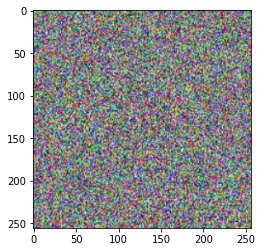

In [ ]:
t = torch.rand((2, 3, 256, 256))
torch.sum(t)
t1 = t[0]
t2 = t1[:,6:194, 31:241]

plt.imshow(t1.permute(1, 2, 0))

plt.imshow(t2.permute(1, 2, 0))

alb = A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH)
print(t2.numpy().shape)
alb(image=t2.numpy())['image'].shape

tnew = torchvision.transforms.Resize((256, 256))(t2)
plt.imshow(tnew.permute(1, 2, 0))
# veerenda

In [ ]:
def inference(image_path):
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  load_checkpoint(model, BASE_DIR + "results/unet_chesxray_mcu_8.pth")
  model.eval()

  image = np.array(Image.open(image_path).convert("RGB"))
  x = validation_transforms(image=image)["image"]
  x = x.unsqueeze(dim=0)
  x = x.to(device=DEVICE)
  preds = torch.sigmoid(model(x))
  preds = (preds > 0.5).float()

  # Convert into 2 dimensional mask image
  preds = preds.squeeze(dim=0)
  preds = preds.squeeze(dim=0)
  preds = preds.to('cpu')
  
  fig = plt.figure()

  fig.add_subplot(1,2,1)
  plt.axis('off')
  plt.imshow(image)
  plt.title("CXR")

  fig.add_subplot(1,2,2)
  plt.axis('off')
  plt.imshow(preds)
  plt.title("Mask")

  plt.show()

  # torchvision.utils.save_image(preds, "output.png")

In [ ]:
from math import e
def load_segmentation_model():
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  load_checkpoint(model, BASE_DIR + "results/unet_chesxray_mcu_8.pth")
  model.eval()
  return model

def lung_region_generator(batched_images_tensor, segmentation_model=None):
  if segmentation_model is None:
    segmentation_model = load_segmentation_model()
  masks = segmentation_model(batched_images_tensor)
  print(f'Masks: {masks.shape}')
  return masks


segmentation_model = load_segmentation_model()


"""
validation_dataset = CXRMaskDataset(validation_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=validation_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=4, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)    
for i, (x, y) in enumerate(validation_loader):
  print(i, x.shape, y.shape)
  x = x.to(device=DEVICE)
  y = y.float().unsqueeze(1).to(device=DEVICE)
  masks = lung_region_generator(x, segmentation_model)
  lung_region_images = lung_region_image_generator(x, masks)
  lung_region_images = lung_region_images.to(device=DEVICE)

  grid = torchvision.utils.make_grid(x, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  grid = torchvision.utils.make_grid(y, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  grid = torchvision.utils.make_grid(masks, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  grid = torchvision.utils.make_grid(lung_region_images, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  
  break
"""

=> Loading checkpoint /content/DataSets/LungSegmentationDataset/results/unet_chesxray_mcu_8.pth


AttributeError: ignored

In [ ]:
#dict(segmentation_model.named_modules())
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(segmentation_model)

31037633

In [ ]:
def main():
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_dataset = CXRMaskDataset(train_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)


    validation_dataset = CXRMaskDataset(validation_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=validation_transforms)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)    

    if LOAD_MODEL:
        load_checkpoint(model, BASE_DIR + "results/unet_chesxray_mcu_8.pth")

    check_accuracy(validation_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()
    train_losses, train_accuracies, validate_accuracies = [], [], []


    results = []
    for epoch in range(NUM_EPOCHS):
        train_loss = train(train_loader, model, optimizer, loss_fn, scaler)
        train_losses.append(train_loss)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, BASE_DIR + "results/unet_chesxray_mcu_" + str(epoch) + ".pth")

        # check accuracy
        dice_score = check_accuracy(train_loader, model, device=DEVICE)
        train_accuracies.append(dice_score.item())
        dice_score = check_accuracy(validation_loader, model, device=DEVICE)
        validate_accuracies.append(dice_score.item())

        # print some examples to a folder
        save_predictions_as_imgs(validation_loader, model, folder = BASE_DIR + 'results/saved_images', device=DEVICE)

        results = pd.DataFrame({'Iteration': range(len(train_losses)), 
                                'Training Loss': train_losses,
                                'Training Dice Accuracy': train_accuracies,
                                'Validation Dice Accuracy': validate_accuracies})
        results.to_csv(BASE_DIR + 'results/summary.csv')
        print(results)
    return results

In [ ]:
#summary = main()

In [ ]:
#summary = main()

In [ ]:
test_img_path = '/content/DataSets/LungSegmentationDataset/CXR_png/CHNCXR_0276_0.png'
test_img_path = '/content/NIH/00006585_014.png'
#inference(test_img_path)

In [ ]:
#!rm /content/results/saved_images/*.png
#!rm {BASE_DIR + 'results/saved_images/*.*'}
!rm {BASE_DIR + 'results/*.pth'}

rm: cannot remove '/content/DataSets/LungSegmentationDataset/results/*.pth': No such file or directory


In [ ]:
#!ls /content/drive/MyDrive/Colab\ Notebooks/
!mkdir -p /content/drive/MyDrive/Colab\ Notebooks/ModelResults/UNet/result1/saved_images
!cp -v /content/DataSets/LungSegmentationDataset/results/unet_chesxray_mcu_8.pth /content/drive/MyDrive/Colab\ Notebooks/ModelResults/UNet/result1/
!cp -v /content/DataSets/LungSegmentationDataset/results/summary.csv /content/drive/MyDrive/Colab\ Notebooks/ModelResults/UNet/result1/
!cp -v /content/DataSets/LungSegmentationDataset/results/saved_images/*.* /content/drive/MyDrive/Colab\ Notebooks/ModelResults/UNet/result1/saved_images/

In [ ]:
!cp -v /content/drive/MyDrive/Colab\ Notebooks/ModelResults/UNet/result1/unet_chesxray_mcu_8.pth  /content/DataSets/LungSegmentationDataset/results/

'/content/drive/MyDrive/Colab Notebooks/ModelResults/UNet/result1/unet_chesxray_mcu_8.pth' -> '/content/DataSets/LungSegmentationDataset/results/unet_chesxray_mcu_8.pth'


In [ ]:
train_dataset = CXRMaskDataset(train_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)    

for i, (x, y) in enumerate(train_loader):
  print(i, x.shape, y.shape)
  x = x.to(device=DEVICE)
  y = y.float().unsqueeze(1).to(device=DEVICE)
  grid = torchvision.utils.make_grid(x, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  grid = torchvision.utils.make_grid(y, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)    

  break

In [ ]:
validation_dataset = CXRMaskDataset(validation_indices, image_names, mask_names, IMAGE_DIR, MASK_DIR, transform=validation_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)    
for i, (x, y) in enumerate(validation_loader):
  print(i, x.shape, y.shape)
  x = x.to(device=DEVICE)
  y = y.float().unsqueeze(1).to(device=DEVICE)
  grid = torchvision.utils.make_grid(x, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)

  grid = torchvision.utils.make_grid(y, nrow=8)
  grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
  plt.matshow(grid_np)    

  break

In [ ]:
train_losses, train_accuracies, validate_accuracies = [], [], []

train_losses.append(1)
train_losses.append(2)

train_accuracies.append(3)
train_accuracies.append(4)
pd.DataFrame({'Iteration': range(len(train_losses)), 
              'Training Loss': train_losses,
              'Training Dice Accuracy': train_accuracies}).to_csv('results.csv')